In [2]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson

#to en otra carpeta
sns.set_theme()

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (1)$$

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right]$$

In [3]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b




# Cambio de corriente a distancia focal
def focalcurr(ecu,corr):
  '''
  Cambio de corriente [mA] a distancia focal [m]

  Parametros
  ----------
  ecu: String
      Parametro tipo cadena 'opt1' o 'opt2' dependiendo
      del tipo de ecuación de ajuste.
  corr: Arreglo
      Arreglo con distancias focales utilizadas.

  La función devuelve la distancia focal
  '''
  if(ecu=='opt1'):
      focal = 1/(0.045*corr + 1.522)
  elif(ecu=='opt2'):
      focal = (1/(5.9e-5*corr + 4.9e-3) + 1.7)*1e-3
  return focal

def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
   
    señal_ruido=np.zeros(len(señal))
    señal_ruido=[ np.random.normal(señal[i], desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

# Archivo con los datos que se asumiran como reales.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)

Text(0, 0.5, 'Distancia focal [cm]')

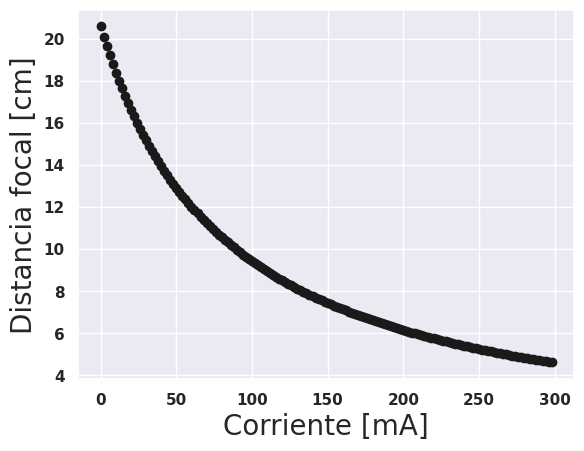

In [4]:
# Señal con ruido.
# Corriente con menos puntos cerca de la caida.
corriente=[i for i in range(0,300,2)]

corriente=np.array(corriente)
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]

plt.plot(corriente,focal*100,'ko')
plt.xlabel('Corriente [mA]',fontsize=20)
plt.ylabel('Distancia focal [cm]',fontsize=20)

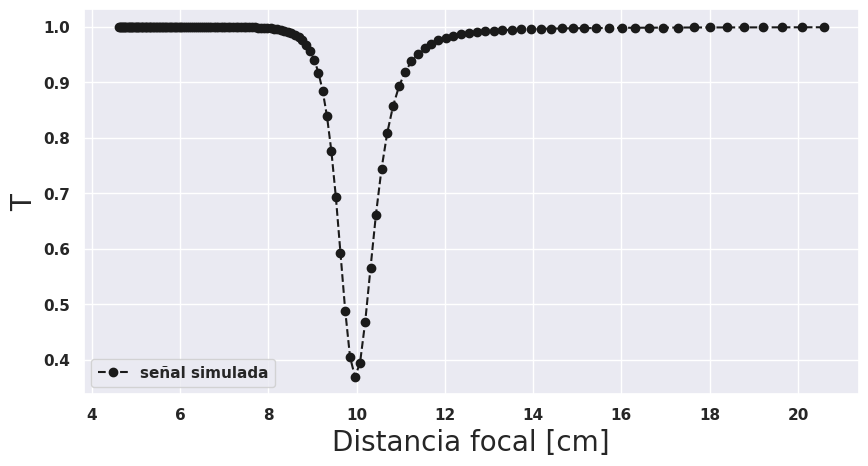

In [5]:
# Señal con ruido.
# Corriente con menos puntos cerca de la caida.
fig=plt.figure(figsize=(10,5))
corriente=[i for i in range(0,300,2)]

corriente=np.array(corriente)
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 100e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ


T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
#Td= np.gradient(T)

#Pavg=Pavg+0.05*Pavg
#L=L+0.05*L
#ds=ds+0.05*ds
plt.plot(focal*100,T,'--ko',label='señal simulada')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('Distancia focal [cm]',fontsize=20)
plt.legend()


In [58]:
def dist_betas(N,desv,k): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]

  L_c = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
  L_e = float(df.loc['L_e']['Valor'])*float(df.loc['L_e']['Valor2']) # thickness error

  Pavg_c = float(df.loc['Pavg_c']['Valor'])*float(df.loc['Pavg_c']['Valor2']) # Average power in (W)
  Pavg_e = float(df.loc['Pavg_e']['Valor'])*float(df.loc['Pavg_e']['Valor2']) # Average power error

  Tp_c = float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
  Tp_e = float(df.loc['Tp_e']['Valor'])*float(df.loc['Tp_e']['Valor2']) # pulse width error

  wl_c = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
  wl_e = float(df.loc['wl_e']['Valor'])*float(df.loc['wl_e']['Valor2']) # central wavelength error

  D_c = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
  D_e = float(df.loc['D_e']['Valor'])*float(df.loc['D_e']['Valor2']) # beam diameter error
  
  ds_c = float(df.loc['ds_c']['Valor'])*float(df.loc['ds_c']['Valor2']) # Distance EFTL-sample (m)
  ds_e = float(df.loc['ds_e']['Valor'])*float(df.loc['ds_e']['Valor2']) # distance EFTL-sample error

  Cf_c = float(df.loc['Cf_c']['Valor']) # beam correction coeff
  Cf_e = float(df.loc['Cf_e']['Valor'])

  alfa_c = float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
  alfa_e = float(df.loc['alfa_e']['Valor'])

  R_c = float(df.loc['R_c']['Valor']) # reflection percentage 
  R_e = float(df.loc['R_e']['Valor'])

  freq_c = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
  freq_e = float(df.loc['freq_e']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)

  TT=list(fscanTH2(focal,beta,L_c,Pavg_c,Tp_c,wl_c,D_c,ds_c,Cf_c,alfa_c,R_c,freq_c)) #Señal simulada
  trans=TT[k] #Minimo de la señal simulada. 
  f=focal[k]  #Distancia focal correspondiente al minimo.   
  for ii in range(N):
      er=desv/100
      er_L=er
      er_P=er
      er_T=er
      er_wl=er*0
      er_D=er*0
      er_ds=er*0
      er_Cf=er*0
      er_a=er*0
      er_R=er*0
      er_freq=er*0
      er_trans=er*0
      er_focal=er*0
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L_c,L_c*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg_c,Pavg_c*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp_c,Tp_c*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl_c,wl_c*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D_c,D_c*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds_c,ds_c*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf_c,Cf_c*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa_c,alfa_c*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R_c,R_c*er_R,1) # Reflectance
      freq_f = np.random.normal(freq_c,freq_c*er_freq,1) # Reflectance
      trans_f= np.random.normal(trans,trans*er_trans,1)
      focal_f=np.random.normal(f,f*er_focal,1)
      
      TPA.append(round(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11,4))
      
    
  return TPA

KstestResult(statistic=1.0, pvalue=0.0)
ShapiroResult(statistic=0.9976233243942261, pvalue=0.7046793699264526)
A-D statistic: 0.2106552369508563
Critical values: [0.571 0.651 0.781 0.911 1.083]
Significance levels: [15.  10.   5.   2.5  1. ]


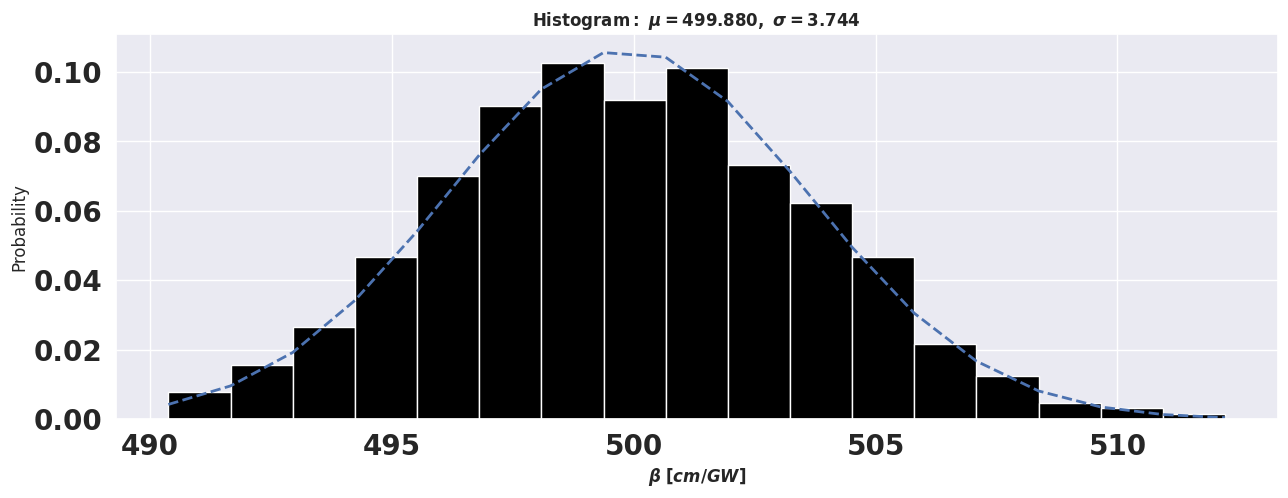

In [59]:
from scipy.stats import kstest
from scipy.stats import shapiro 

f=plt.figure(figsize=(15,5))

er_r=0.5
beta_hist=np.array(dist_betas(500,er_r,10))

(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='black')

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'b--', linewidth=2)

error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
#plot

plt.ylabel('Probability')
plt.xlabel(r'$\beta$ $[cm/GW]$')
plt.title(r'$\mathrm{Histogram:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

# 

result = (anderson(np.sort(beta_hist), dist='norm'))
#perform Kolmogorov-Smirnov test
print(kstest(np.sort(beta_hist), 'norm'))
print(shapiro(np.sort(beta_hist)))
print(f"A-D statistic: {result[0]}")
print(f"Critical values: {result[1]}")
print(f"Significance levels: {result[2]}")


In [60]:
f=plt.figure(figsize=(15,5))

beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,9,50) #  Porcentaje de error
final=np.zeros((len(er_r),len(focal)))
M_sigma=np.zeros((len(er_r),len(focal)))
M_beta=np.zeros((len(er_r),len(focal)))

for k in range(len(focal)):

    for c,j in enumerate(er_r):


        beta_hist=np.array(dist_betas(500,j,k))
        criterio=((result[0]<result[1][3])or(shapiro(np.sort(beta_hist))[1]>0.05))*1       
        result = (anderson(np.sort(beta_hist), dist='norm'))
        final[c,k]=criterio

        
        if criterio==1:
            (mu, sigma) = norm.fit(beta_hist)
            M_sigma[c,k]=sigma
            M_beta[c,k]=mu           

            
        else:
            M_sigma[c,k]=0
            M_beta[c,k]=0


<Figure size 1500x500 with 0 Axes>

In [65]:
corriente=[i for i in range(0,300,2)]
corriente=np.array(corriente)
focal=focalcurr('opt2',corriente) #focal distance [m]
focal=np.round(focal*100,0)

([<matplotlib.axis.YTick at 0x7f66adbbed10>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '1.474'),
  Text(0, 16, '2.942'),
  Text(0, 24, '4.411'),
  Text(0, 32, '5.879'),
  Text(0, 40, '7.348'),
  Text(0, 48, '8.816')])

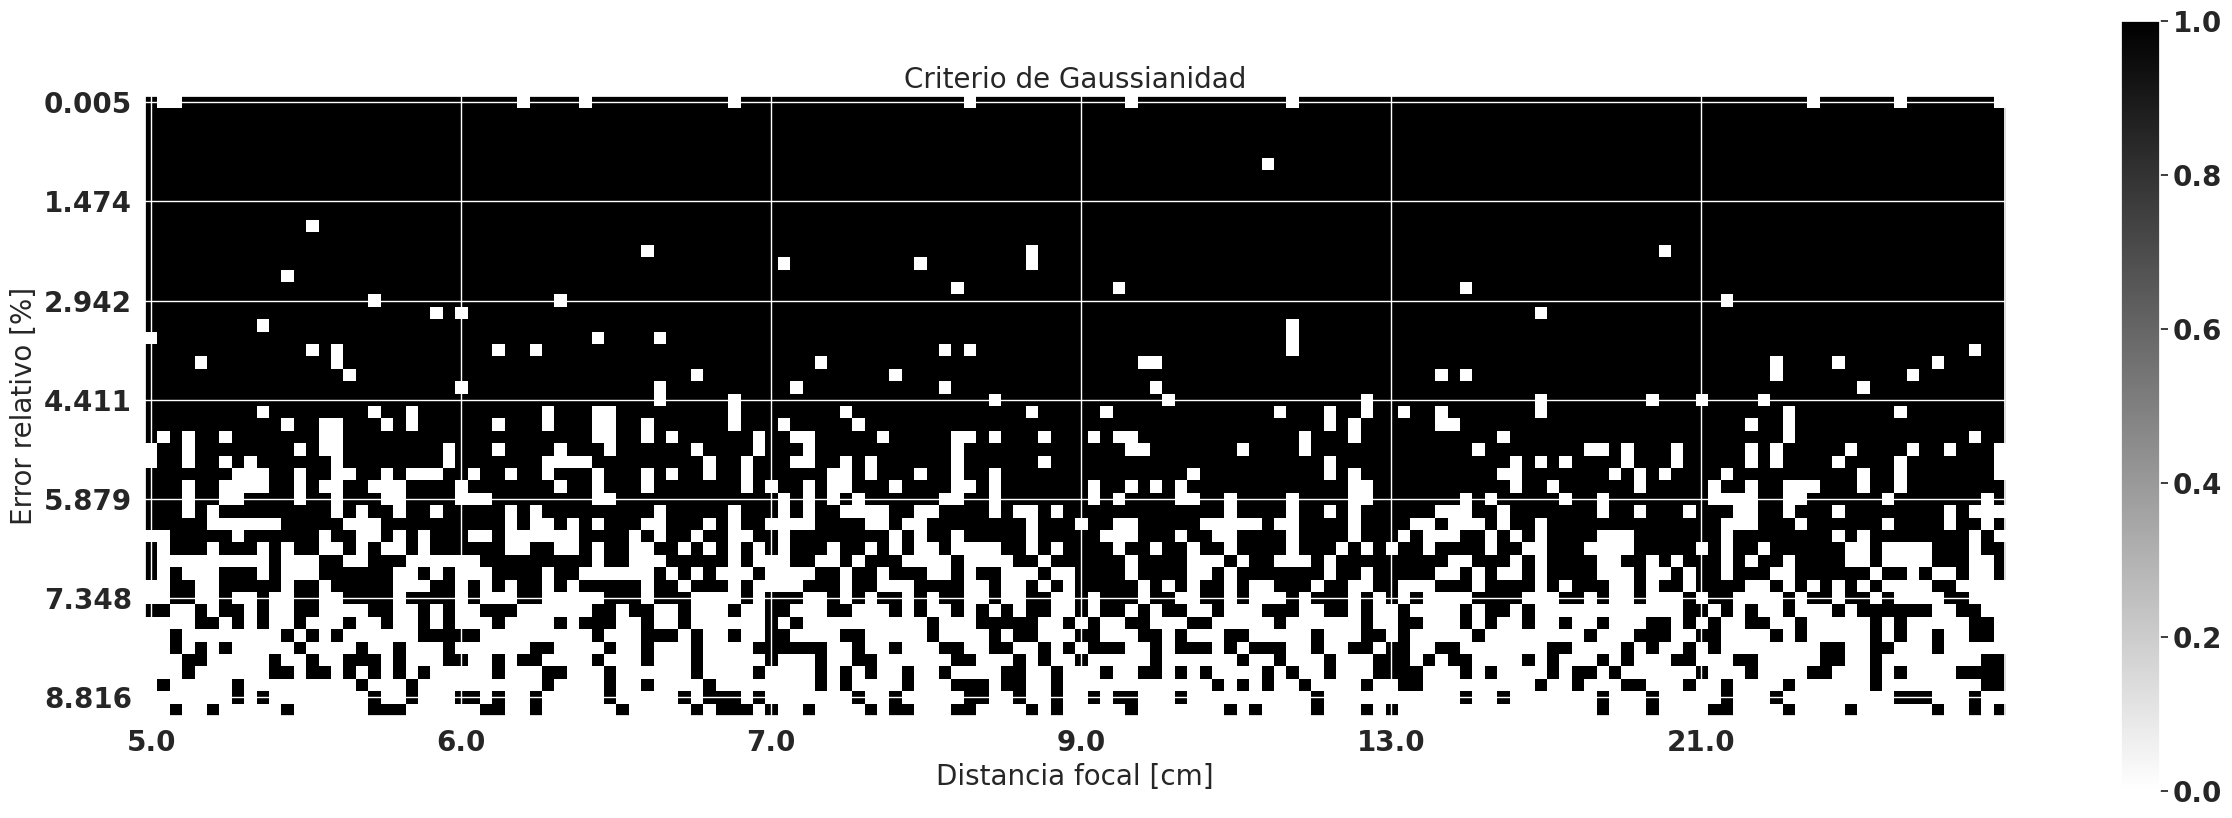

In [70]:
fig = plt.figure(figsize=(30,10))


matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='binary')
plt.ylabel('Error relativo [%]',fontsize=20)
plt.xlabel('Distancia focal [cm]',fontsize=20)
plt.title('Criterio de Gaussianidad',fontsize=20)
plt.colorbar()


nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = focal[::step_x] # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)


ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


([<matplotlib.axis.YTick at 0x7f66ae85a410>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '1.474'),
  Text(0, 16, '2.942'),
  Text(0, 24, '4.411'),
  Text(0, 32, '5.879'),
  Text(0, 40, '7.348'),
  Text(0, 48, '8.816')])

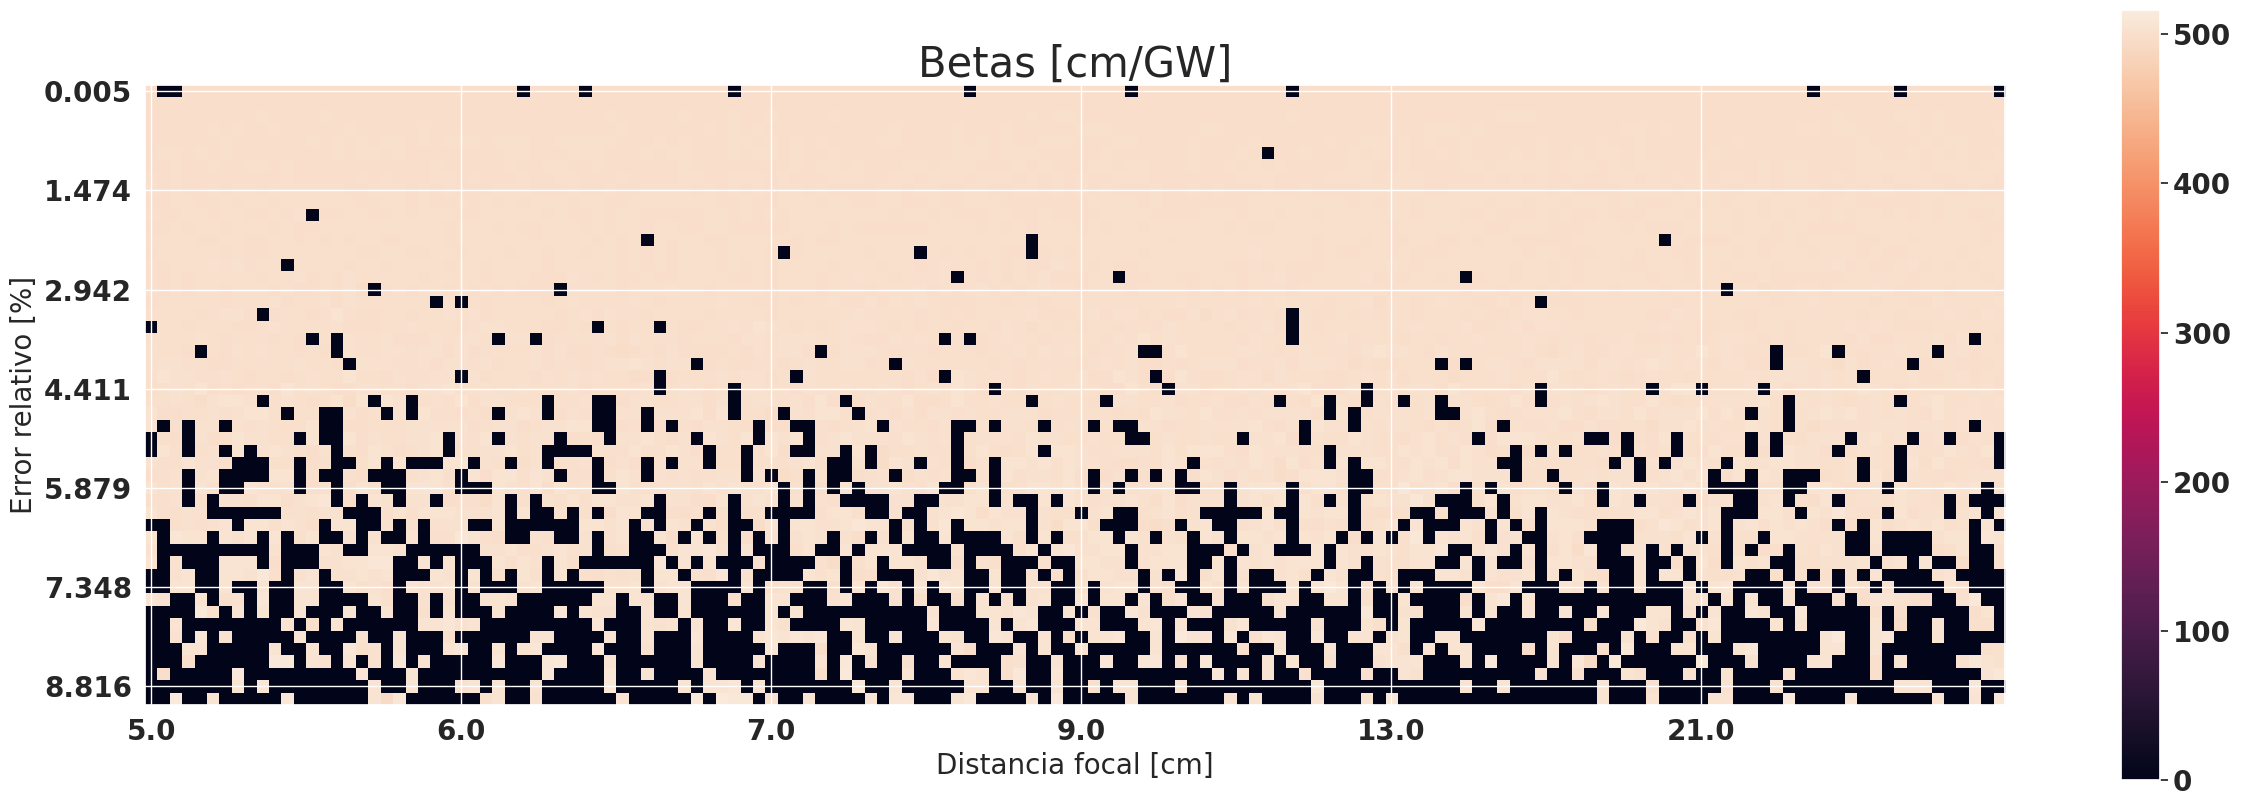

In [71]:
fig = plt.figure(figsize=(30,10))


matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(M_beta)
plt.ylabel('Error relativo [%]',fontsize=20)
plt.xlabel('Distancia focal [cm]',fontsize=20)
plt.title('Betas [cm/GW]',fontsize=30)
plt.colorbar()


nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = focal[::step_x] # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)


ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


([<matplotlib.axis.YTick at 0x7f66ad777340>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '1.474'),
  Text(0, 16, '2.942'),
  Text(0, 24, '4.411'),
  Text(0, 32, '5.879'),
  Text(0, 40, '7.348'),
  Text(0, 48, '8.816')])

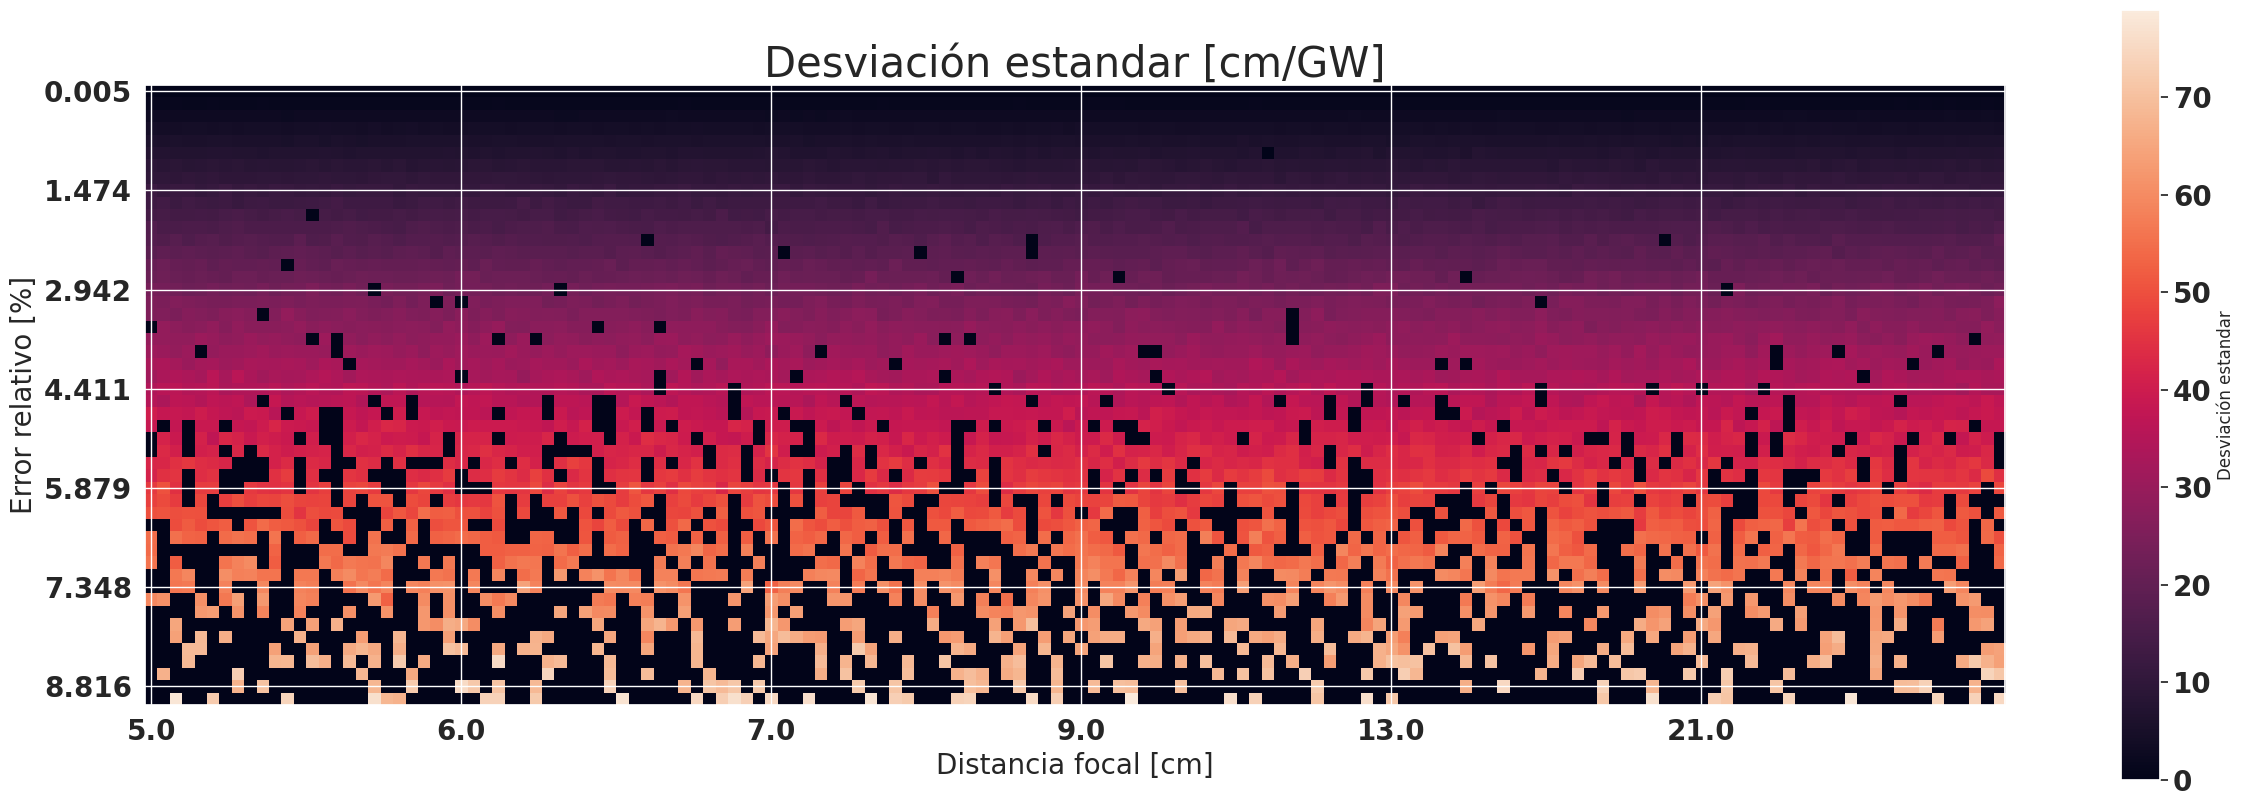

In [68]:
fig = plt.figure(figsize=(30,10))


matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(M_sigma)
plt.ylabel('Error relativo [%]',fontsize=20)
plt.xlabel('Distancia focal [cm]',fontsize=20)
plt.title('Desviación estandar [cm/GW]',fontsize=30)
plt.colorbar(label="Desviación estandar")
nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = focal[::step_x] # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)



ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)